In [1]:
import numpy as np
import h5py
from IPython.display import Image
import glob
import pandas as pd
import sys

import matplotlib
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'large',
         'ytick.labelsize': 'large'}
%matplotlib inline
pylab.rcParams.update(params)

sys.path.insert(1, '/home/ksf293/anomalies-GAN-HSC/analysis')
import utils
import plotter

%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
base_dir = '/scratch/ksf293/anomalies'

In [4]:
gz_fn = f'{base_dir}/data/tables/galaxy-zoo-weird-and-wonderful-classifications-2.csv' 
sub_fn = f'{base_dir}/data/tables/galaxy-zoo-weird-and-wonderful-subjects.csv' 

gz = pd.read_csv(gz_fn, delimiter=',', quotechar='"', skiprows=range(1,100))
sub = pd.read_csv(sub_fn, delimiter=',', quotechar='"')

### Build subject_id to idx dict

In [5]:
subjectid_to_idx_dict = {}
for i in range(len(sub)):
    subject_id = sub['subject_id'][i]
    metadata = eval(sub['metadata'][i])
    if 'idx' in metadata:
        idx = int(metadata['idx'])
        subjectid_to_idx_dict[subject_id] = idx

### Get images marked as interesting

In [6]:
def get_subjectids_interesting(annotation):
    anno_dict = dict(eval(annotation)[0])
    # if list is empty, return
    if not anno_dict['value']:
        return []
    subject_ids = [int(val_entry['subject']) for val_entry in anno_dict['value']]
    return subject_ids

In [7]:
def subjectids_to_idxs(subject_ids):
    idxs = [subjectid_to_idx_dict[subject_id] for subject_id in subject_ids]
    return idxs

In [8]:
gz['subjectids_interesting'] = gz['annotations'].apply(get_subjectids_interesting)
gz['idxs_interesting'] = gz['subjectids_interesting'].apply(subjectids_to_idxs)

In [9]:
idxs_int = np.concatenate(gz['idxs_interesting']).astype(int)
idxs_int_set = np.array(list(set(idxs_int)))
n_idx = len(idxs_int_set)

print("Number of images anyone clicked as interesting:", n_idx)
print("Number of groups (16-image sets) classified:", len(gz))

Number of images anyone clicked as interesting: 194
Number of groups (16-image sets) classified: 3207


### Get all subject ids shown

In [10]:
def get_subjectids_all(subject_data):
    subject_data_clean = subject_data.replace('null', 'None')
    subject_dict = dict(eval(subject_data_clean))
    subject_ids = []
    for id_key in subject_dict:
        subject_subdict = subject_dict[id_key]
        subject_ids_string = subject_subdict['#group_subject_ids']
        subject_ids.extend(subject_ids_string.split('-'))
    return np.array(subject_ids).astype(int)

In [11]:
gz['subjectids_all'] = gz['subject_data'].apply(get_subjectids_all)

In [12]:
subjectids_all_set = list(set(np.concatenate(gz['subjectids_all'])))
print("Number of unique images shown:", len(subjectids_all_set))

Number of unique images shown: 200


### Plot number of times marked as interesting

In [13]:
ns_int = np.empty(n_idx)
for i, idx in enumerate(idxs_int_set):
    ns_int[i] = len(np.where(idxs_int == idx)[0])

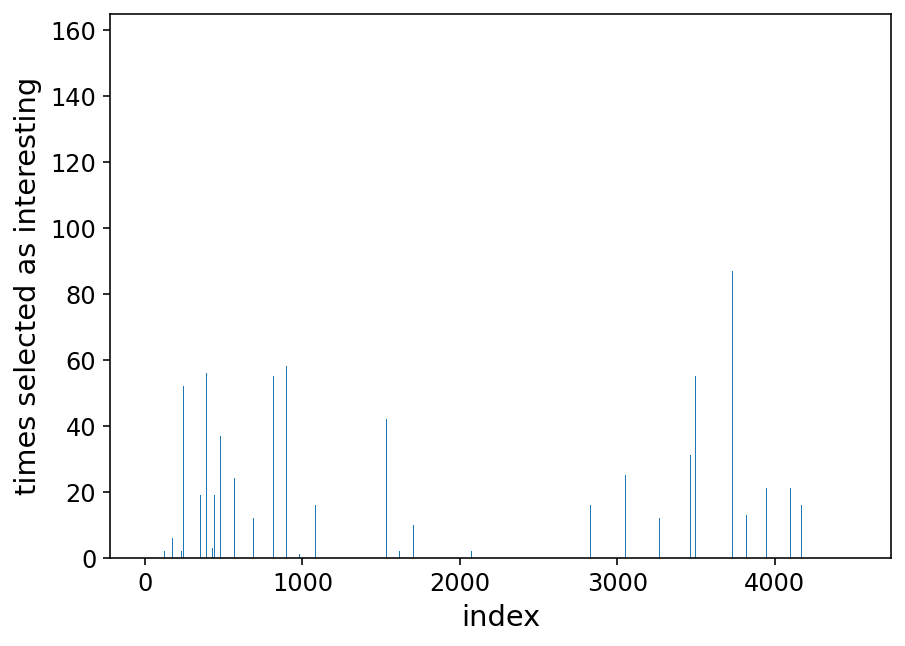

In [14]:
plt.figure(figsize=(7,5))
plt.bar(idxs_int_set, ns_int)
#plt.xticks(idxs_int_set)
plt.xlabel('index')
plt.ylabel('times selected as interesting')
plt.show()

In [15]:
sort_ids = np.argsort(ns_int)
ns_int_sorted = ns_int[sort_ids]
idxs_int_sorted = idxs_int_set[sort_ids]

## Look at images

In [16]:
imtag = 'gri'
tag = 'gri_lambda0.3'
base_dir = '/scratch/ksf293/anomalies'
imarr_fn = f'{base_dir}/data/images_h5/images_{imtag}.h5'
imarr = h5py.File(imarr_fn, 'r')
results_fn = f'{base_dir}/results/results_{tag}.h5'
res = h5py.File(results_fn, 'r')

In [17]:
nrows = 4
ncols = 4
nplot = nrows*ncols

In [18]:
idxs_int_low = idxs_int_sorted[:nplot]
idxs_int_high = idxs_int_sorted[-nplot:]

### Least interesting

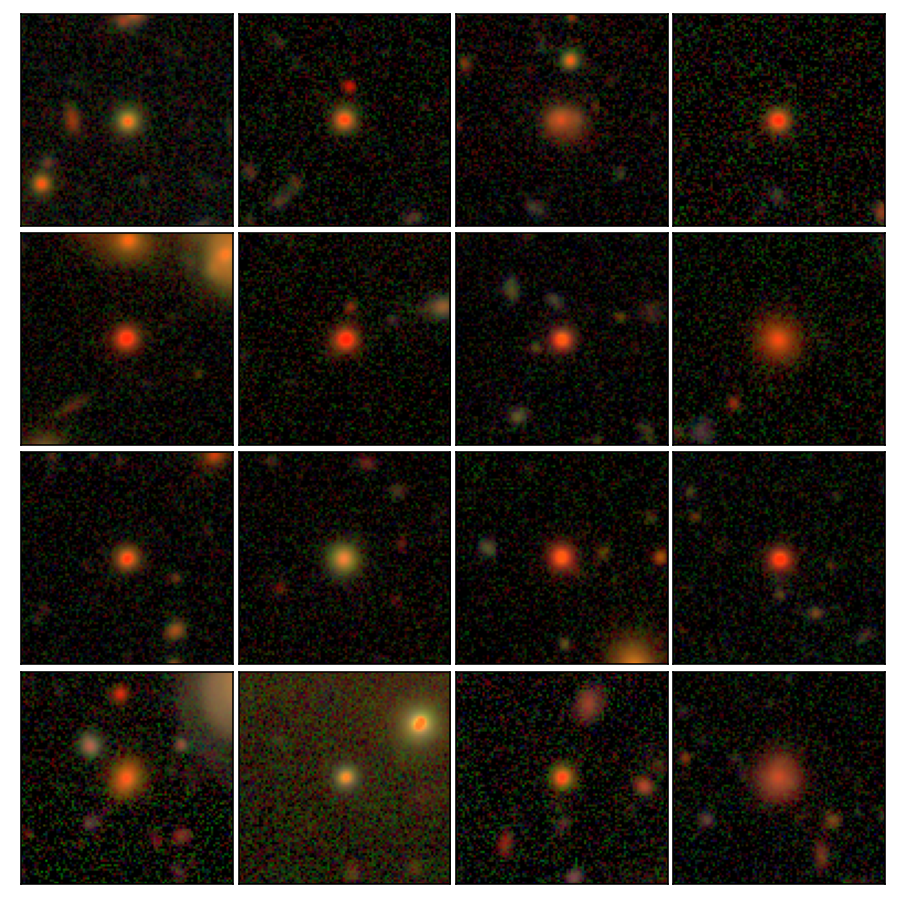

In [19]:
plotter.plot_ims(idxs_int_low, nrows, ncols, tight=True, hspace=0.035, wspace=-0.1)

### Most interesting

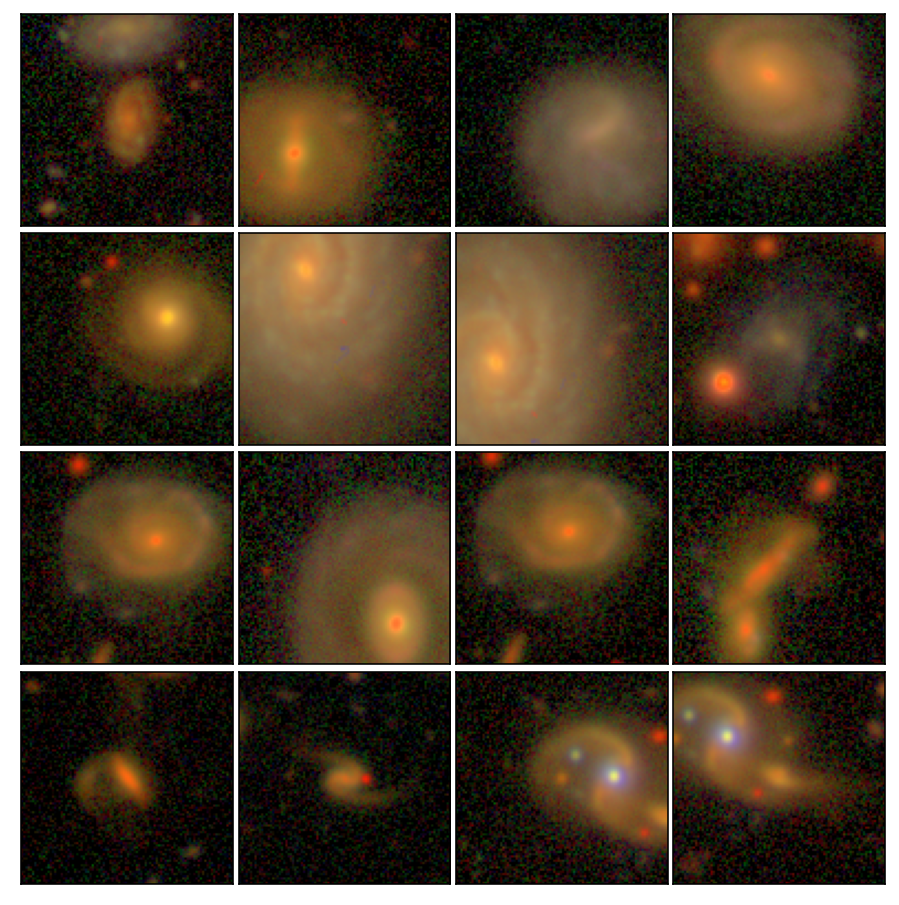

In [20]:
plotter.plot_ims(idxs_int_high, nrows, ncols, tight=True, hspace=0.035, wspace=-0.1)